In [144]:
import nltk
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import shuffle
from string import punctuation

from nltk.corpus import gutenberg
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn import tree
from sklearn import neural_network

# get the book list
bookList = gutenberg.fileids()
# print(bookList)
# books=bookList[0,3,4,5,6,7,8,11]
books = np.array(bookList[3])
# books = np.append(books, bookList[3])
books = np.append(books, bookList[4])
books = np.append(books, bookList[6])
books = np.append(books, bookList[7])
books = np.append(books, bookList[11])
books = np.append(books, bookList[13])
books = np.append(books, bookList[15])

# print(books)
# segment

def sampling(number_samples, sample_size, book_name):
    labeled_records = []
    book = gutenberg.raw(book_name)
    # print(book)
    # tokenize the material of the book
    raw_words = nltk.word_tokenize(book)
    # print(raw_words)
    # Prepare 200 documents for each book
    headers = random.sample(range(0, len(raw_words)), number_samples)

    for header in headers:
        segment = raw_words[header:(header + sample_size + 1)]
        labeled_records.append((segment, book_name))
    return labeled_records


def data_cleaning(sample_words):
    # customize the punctuation list by adding extra string
    extra_string = "'-- ``'' "
    update_punctuation = punctuation + extra_string
    # customize the stopwords list by adding extra stopwords
    sw = stopwords.words('english')
    extra_stopwords = "n't", "'s", "ar't", "'d", "'ll", "i'll"
    sw.extend(extra_stopwords)
    # Remove punctuation
    remove_punct_words = [w for w in sample_words if w not in update_punctuation]
    # Change all letters to lowercase
    lowercase_words = [w.lower() for w in remove_punct_words]
    # Strip "_" at the beginning or end of a word
    strip_words = [w.strip('_') for w in lowercase_words]
    # Remember digits/numbers (keeps only words)
    remove_number_words = [w for w in strip_words if w.isalpha()]
    # Remove stop words
    final_words = [w for w in remove_number_words if w not in sw]
    return final_words
if __name__ == "__main__":
    try_number_samples = 200
    try_sample_size = 100
    final_list = []
    for book_name in books:
        # print (book_name)
        labeled_list = sampling(try_number_samples, try_sample_size, book_name)
        cleaned_labeled_list = []

        for samples in labeled_list:
            book_name = samples[1]

            cleaned_seg = data_cleaning(samples[0])
            cleaned_labeled_seg = (cleaned_seg, book_name)
            # print(cleaned_labeled_seg)
            cleaned_labeled_list.append(cleaned_labeled_seg)
        # print(cleaned_labeled_list)
        final_list = final_list + cleaned_labeled_list
    # shuffle the list
#     shuffle(final_list)
    #print(final_list)

    docs = []
    tags = []

    # word lemmatization
    # lem = WordNetLemmatizer()
    for labeled_doc in final_list:
        docs.append(lem.lemmatize(' '.join(labeled_doc[0])))
        tags.append(labeled_doc[1])
#     print(docs)
    # import data to dictionary
    dic = {'Text': docs, 'File_name': tags}
    # apply pandas data frame
    df = pd.DataFrame(dic)
#     print(df)
    # df.columns = ['Text', 'File_name']
    df['book_id'] = df['File_name'].factorize()[0]
    book_id_df = df[['File_name', 'book_id']].drop_duplicates().sort_values('book_id')
    book_to_id = dict(book_id_df.values)
    id_to_book = dict(book_id_df[['book_id', 'File_name']].values)
    
    # feature engineering： TF-IDF
#     tfidf = TfidfVectorizer(sublinear_tf=True, encoding='latin-1', ngram_range=(1, 2), stop_words='english')
    tfidf = TfidfVectorizer(stop_words='english')
    features = tfidf.fit_transform(df.Text)
#     print(features)

In [145]:
# dimension reducing
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(features.toarray())

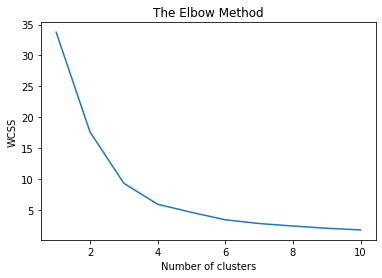

In [146]:
# K-Means Clustering
from sklearn.cluster import KMeans
# Using the elbow method to find the optimal number of clusters (7)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(Y_sklearn)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [147]:
#KMeans clustering
true_k = 7
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=7, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [148]:
model.labels_
# array([4, 0, 0, ..., 2, 4, 3])

array([0, 1, 0, ..., 4, 4, 4])

In [149]:
kmeans_predict = model.predict(features)
print (kmeans_predict)

[0 1 0 ... 4 4 4]


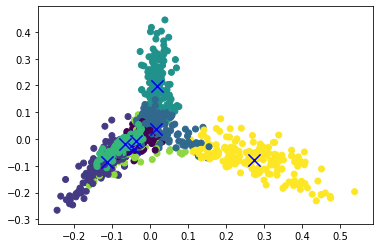

In [175]:
# visualization of KMeans
reduced_cluster_centers = sklearn_pca.transform(model.cluster_centers_)
plt.scatter(Y_sklearn[:,0], Y_sklearn[:,1], c=model.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [151]:
# count the ratio of cluster id in each cluster
# return stat - display the predicted clusters' id distribution
# return new_id - the clusters' id array following the original doc order
def statistics(predict):
    stat = []
    new_id = []
    for i in range(0, 1400, 200):
        ratio = []
        most_possible_id = 0
        max_count = 0
        for j in range(7):
            # count = predict[i:i + 200].count(j)
            counter = collections.Counter(predict[i:i + 200])
            count = counter[j]
            ratio.append(count / 200)
            if count > max_count:
                max_count = count
                most_possible_id = j
        stat.append(ratio)
        new_id.append(most_possible_id)
    return stat, new_id

In [165]:
# obtain cluster id from predict result
import collections
stat, new_id = statistics(kmeans_predict)

In [153]:
predict_df = pd.DataFrame(stat, index = books, columns=['0', '1', '2', '3', '4', '5', '6'])
print(predict_df)
new_id

                             0      1      2      3      4     5     6
bible-kjv.txt            0.265  0.705  0.020  0.000  0.010  0.00  0.00
blake-poems.txt          0.200  0.145  0.085  0.000  0.000  0.57  0.00
burgess-busterbrown.txt  0.005  0.000  0.135  0.000  0.000  0.00  0.86
carroll-alice.txt        0.035  0.000  0.090  0.875  0.000  0.00  0.00
edgeworth-parents.txt    0.305  0.000  0.690  0.005  0.000  0.00  0.00
milton-paradise.txt      0.785  0.200  0.015  0.000  0.000  0.00  0.00
shakespeare-hamlet.txt   0.030  0.060  0.005  0.000  0.905  0.00  0.00


[1, 5, 6, 3, 2, 0, 4]

In [154]:
# create new book id
ids = []
for k in new_id:
    arr = np.ones(200)
    ids.append(arr * k)
book_cluster_ids = np.array(ids,dtype='int8').flatten()
# assign new book id to the df
df['cluster_id'] = book_cluster_ids
df.cluster_id

0       1
1       1
2       1
3       1
4       1
       ..
1395    4
1396    4
1397    4
1398    4
1399    4
Name: cluster_id, Length: 1400, dtype: int8

In [157]:
#evaluation of KMeans
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(df.cluster_id, kmeans_predict))

0.7316666666666667


In [159]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
print(homogeneity_score(df.cluster_id, kmeans_predict))
silhouette_score(features, labels=kmeans_predict)

0.659062720490503


0.014676206957256863

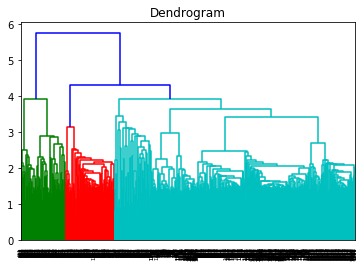

In [160]:
# Using the dendrogram to find the optimal number of clusters (7)
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(features.toarray(), method = 'ward'))
plt.title('Dendrogram')
plt.show()

In [161]:
#EM clustering
gmm = GaussianMixture(n_components=7).fit(Y_sklearn)
labels = gmm.predict(Y_sklearn)
labels

array([5, 1, 3, ..., 1, 3, 1], dtype=int64)

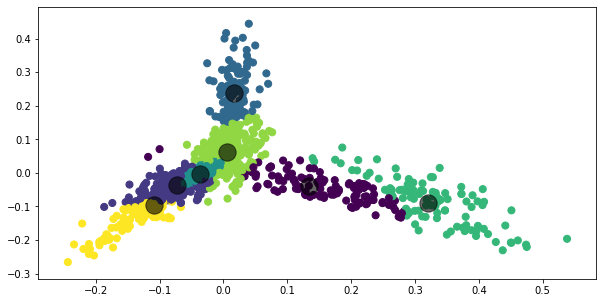

In [162]:
from scipy.stats import multivariate_normal as mvn
centers = np.zeros((7,2))
for i in range(7):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(Y_sklearn)
    centers[i, :] = Y_sklearn[np.argmax(density)]
plt.figure(figsize = (10,5))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=labels ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);
plt.show()

In [169]:
# obtain cluster id from predict result
em_predict = gmm.predict(Y_sklearn)
stat, new_id = statistics(em_predict)
predict_df = pd.DataFrame(stat, index = books, columns=['0', '1', '2', '3', '4', '5', '6'])
print(predict_df)
print(new_id)
# create new book id
ids = []
for k in new_id:
    arr = np.ones(200)
    ids.append(arr * k)
book_cluster_ids = np.array(ids,dtype='int8').flatten()
# assign new book id to the df
df['cluster_id'] = book_cluster_ids
df.cluster_id

                             0      1     2      3    4      5      6
bible-kjv.txt            0.010  0.450  0.00  0.235  0.0  0.025  0.280
blake-poems.txt          0.060  0.325  0.00  0.275  0.0  0.175  0.165
burgess-busterbrown.txt  0.485  0.000  0.00  0.000  0.5  0.015  0.000
carroll-alice.txt        0.000  0.000  0.55  0.015  0.0  0.435  0.000
edgeworth-parents.txt    0.020  0.005  0.00  0.340  0.0  0.635  0.000
milton-paradise.txt      0.000  0.250  0.00  0.570  0.0  0.035  0.145
shakespeare-hamlet.txt   0.000  0.455  0.00  0.465  0.0  0.015  0.065
[1, 1, 4, 2, 5, 3, 3]


0       1
1       1
2       1
3       1
4       1
       ..
1395    3
1396    3
1397    3
1398    3
1399    3
Name: cluster_id, Length: 1400, dtype: int8

In [170]:
#evaluation of EM
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(df.cluster_id, em_predict))

0.38423892583762076


In [168]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
print(homogeneity_score(df.cluster_id, gmm.predict(Y_sklearn)))
silhouette_score(features, labels=gmm.predict(Y_sklearn))

0.4199454370716115


0.005633728430850048

In [172]:
# Hierarchy clustering
# Training the Hierarchical Clustering model on the dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 7, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(features.toarray())

print(len(y_hc))
print(y_hc)
hc.n_clusters_

1400
[5 5 0 ... 0 0 0]


7

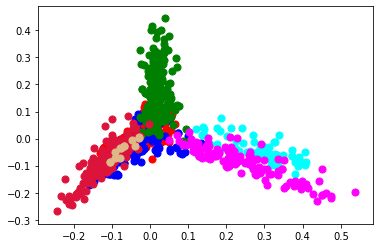

In [173]:
# Visualising the clusters
plt.scatter(Y_sklearn[y_hc == 0, 0], Y_sklearn[y_hc == 0, 1], s = 50, c = 'red', label = 'Cluster 1')
plt.scatter(Y_sklearn[y_hc == 1, 0], Y_sklearn[y_hc == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(Y_sklearn[y_hc == 2, 0], Y_sklearn[y_hc == 2, 1], s = 50, c = 'green', label = 'Cluster 3')
plt.scatter(Y_sklearn[y_hc == 3, 0], Y_sklearn[y_hc == 3, 1], s = 50, c = 'cyan', label = 'Cluster 4')
plt.scatter(Y_sklearn[y_hc == 4, 0], Y_sklearn[y_hc == 4, 1], s = 50, c = 'magenta', label = 'Cluster 5')
plt.scatter(Y_sklearn[y_hc == 5, 0], Y_sklearn[y_hc == 5, 1], s = 50, c = 'crimson', label = 'Cluster 6')
plt.scatter(Y_sklearn[y_hc == 6, 0], Y_sklearn[y_hc == 6, 1], s = 50, c = 'burlywood', label = 'Cluster 7')
plt.show()

In [174]:
# obtain cluster id from predict result
hc_predict = y_hc
stat, new_id = statistics(hc_predict)
predict_df = pd.DataFrame(stat, index = books, columns=['0', '1', '2', '3', '4', '5', '6'])
print(predict_df)
print(new_id)
# create new book id
ids = []
for k in new_id:
    arr = np.ones(200)
    ids.append(arr * k)
book_cluster_ids = np.array(ids,dtype='int8').flatten()
# assign new book id to the df
df['cluster_id'] = book_cluster_ids
df.cluster_id

                             0     1      2     3     4      5      6
bible-kjv.txt            0.355  0.00  0.000  0.00  0.00  0.645  0.000
blake-poems.txt          0.185  0.71  0.000  0.00  0.00  0.040  0.065
burgess-busterbrown.txt  0.025  0.01  0.025  0.33  0.61  0.000  0.000
carroll-alice.txt        0.095  0.00  0.900  0.00  0.00  0.005  0.000
edgeworth-parents.txt    0.900  0.00  0.095  0.00  0.00  0.005  0.000
milton-paradise.txt      0.775  0.00  0.005  0.00  0.00  0.220  0.000
shakespeare-hamlet.txt   0.975  0.00  0.000  0.00  0.00  0.025  0.000
[5, 1, 4, 2, 0, 0, 0]


0       5
1       5
2       5
3       5
4       5
       ..
1395    0
1396    0
1397    0
1398    0
1399    0
Name: cluster_id, Length: 1400, dtype: int8

In [176]:
print(homogeneity_score(df.File_name, hc.labels_))
silhouette_score(features, labels=hc.labels_)

0.5138878188319123


0.011607509090429952